In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray'

import pollux

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten, BatchNormalization, Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, LeakyReLU, Concatenate, Lambda, Multiply
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TerminateOnNaN, ModelCheckpoint


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.

def gen_mnist(x, batch_size):
    while True:
        w = np.random.choice(len(x), size=batch_size, replace=False)
        x_batch = x[w]
        yield x_batch, x_batch

In [3]:
# Mock data and val generator
batch_size = 32

ntrain = len(x_train)
nval = len(x_test)

traingen = gen_mnist(x_train, batch_size)
valgen = gen_mnist(x_test, batch_size)

In [4]:
input_shape = x_train.shape[1:]
output_shape = x_train.shape[1:]
original_dim = np.prod(input_shape)
latent_dim = 8
hidden_dim = 128
filters = [32, 64, 128]
kernels = [3,3,3]

In [5]:
def build_encoder(latent_dim, hidden_dim, filters, kernels, conv_activation='softplus', dense_activation='softplus'):
    input_layer = Input(shape=input_shape)
    h = input_layer
    # h = pollux.layers.AddPoissonNoise(training_only=True, sky_level=sky_level_pixel, N_exposures=N_exposures)(h)
    h = BatchNormalization()(h)
    for i in range(len(filters)):
        h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=None, padding='same')(h)
        h = pollux.activations.add_activation(h, conv_activation)
        h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=None, padding='same', strides=(2,2))(h)
        h = pollux.activations.add_activation(h, conv_activation)
    h = Flatten()(h)
    h = Dense(hidden_dim, activation=None)(h)
    h = pollux.activations.add_activation(h, dense_activation)
    mu = Dense(latent_dim)(h)
    sigma = Dense(latent_dim, activation='softplus_eps')(h)
    return Model(input_layer, [mu, sigma], name='encoder')

In [6]:
encoder = build_encoder(latent_dim, hidden_dim, filters, kernels,
                        conv_activation='PReLU', dense_activation='PReLU')

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 28, 28, 32)   25088       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (

In [8]:
def build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation='softplus', dense_activation='softplus'):
    input_layer = Input(shape=(latent_dim,))
    h = Dense(hidden_dim, activation=None)(input_layer)
    h = pollux.activations.add_activation(h, dense_activation)
    
    # Dense and reshape to symmetric of encoder
    w = int(np.ceil(input_shape[0]/2**(len(filters))))
    h = Dense(w*w*filters[-1], activation=None)(h)
    h = pollux.activations.add_activation(h, dense_activation)
    h = Reshape((w,w,filters[-1]))(h)

    # Conv layers
    for i in range(len(filters)-1,-1,-1):
        h = Conv2DTranspose(filters[i], (kernels[i],kernels[i]), activation=None, padding='same', strides=(2,2))(h)
        h = pollux.activations.add_activation(h, conv_activation)
        h = Conv2DTranspose(filters[i], (kernels[i],kernels[i]), activation=None, padding='same')(h)
        h = pollux.activations.add_activation(h, conv_activation)
        
    h = Conv2D(input_shape[-1], (3,3), activation='sigmoid', padding='same',
               kernel_regularizer=None, bias_regularizer=None)(h)
    
    # Cropping to match input size
    cropping = int(h.get_shape()[1]-input_shape[0])
    if cropping>0:
        if cropping % 2 == 0:
            h = Cropping2D(cropping//2)(h)
        else:
            h = Cropping2D(((cropping//2,cropping//2+1),(cropping//2,cropping//2+1)))(h)
            
    return Model(input_layer, h, name='decoder')

In [9]:
decoder = build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels,
                        conv_activation='PReLU', dense_activation='PReLU')

In [10]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1152      
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 128)               128       
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              264192    
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 2048)              2048      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         147584    
__________

In [11]:
vae, vae_utils = pollux.vae.build_vanilla_vae(encoder, decoder, full_cov=False, coeff_KL=0.1)

In [12]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 606260      input_3[0][0]                    
__________________________________________________________________________________________________
sample_multivariate_gaussian (S [(None, 8), (None,)] 0           encoder[1][0]                    
                                                                 encoder[1][1]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    816097      sample_multivariate_gaussian[0][0
Total para

In [13]:
vae.compile('adam', loss=pollux.vae.vae_rec_loss, metrics=['mse'])

In [14]:
callbacks = [ReduceLROnPlateau(),
             # ModelCheckpoint('./weights/test_weights.{epoch:02d}-{val_loss:.2f}.hdf5', period=5),
             pollux.vae.VAEHistory(x_test[:100], vae_utils, latent_dim, plot_bands=0, figname='VAEHistory.png'),
            ]

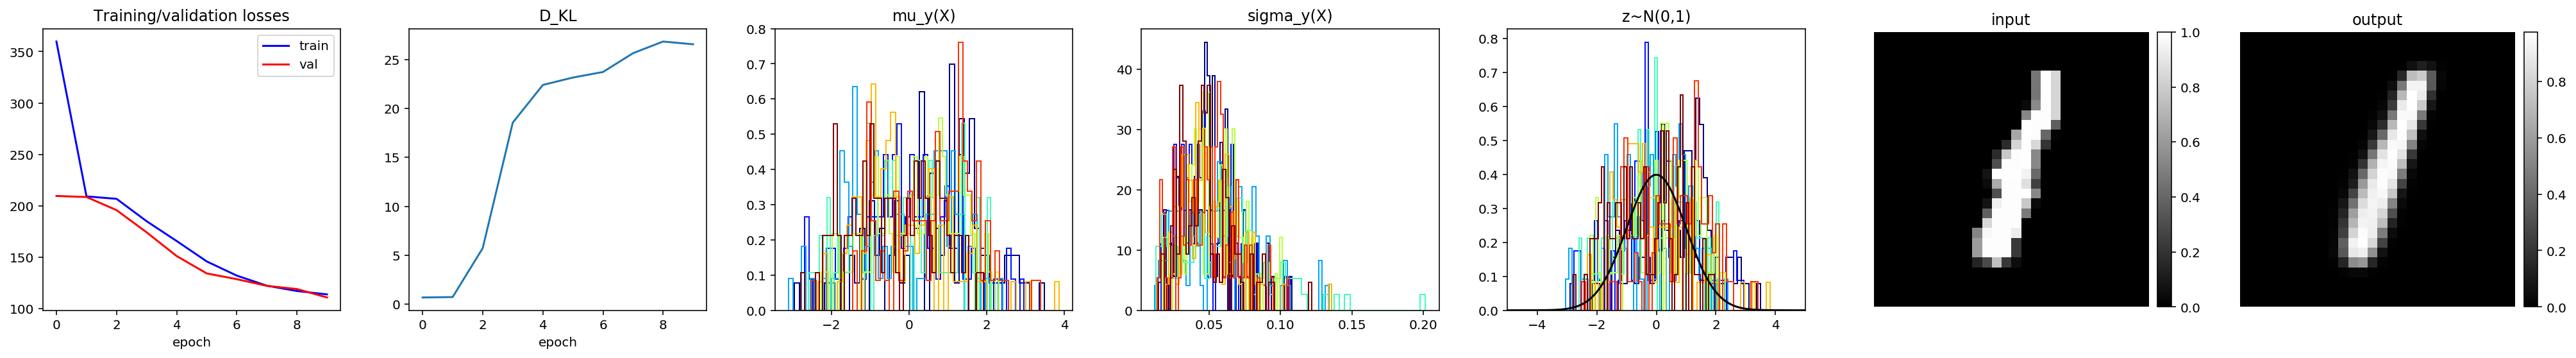

50/50 [==============================] - 20s 396ms/step - loss: 113.7966 - mean_squared_error: 0.0269 - val_loss: 110.8121 - val_mean_squared_error: 0.0259


In [15]:
vae.fit_generator(generator=traingen, epochs=10,
                  steps_per_epoch=50, #int(ntrain/batch_size)//10,
                  validation_data=valgen,
                  validation_steps=10, #int(nval/batch_size)//10,
                  callbacks=callbacks,
                  workers=0,
                  initial_epoch=0)